In [ ]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


Now we are ultizing only attention for decoder layer. We followed the decoder model structure from the paper "Attention is All you need" to create a decoder with no RNN structure in it. Moreover, we are using the learnable positional encoding instead of using the sinusodial (sin , cos) functions. The idea comes from BERT and ViT.

## Image Captioning Model with Pretrained CNN + Attention Only

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

import collections
import re
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

from PIL import Image
from torchvision.transforms import transforms
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


## Data Load and Transform

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/captions.txt')
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print('total number of unique image: ', len(df['image'].unique()))
print('total number of df: ', len(df))

## plan to use 6091 for training, 1000 for val and 1000 for test

## [0:6091*5 = 30455 ] traing
## [30455:35455,:] val
## [35355: , :] test

total number of unique image:  8091
total number of df:  40455


In [ ]:
df_train = df.iloc[:30455, :].reset_index()
df_val = df.iloc[30455:35455,:].reset_index()
df_test= df.iloc[35455:,:].reset_index()

print(len(df_train))
print(len(df_val))
print(len(df_test))

30455
5000
5000


In [ ]:
class Vocab:
    def __init__(self, tokens = None, minimum_frequency = 0 , reserved_tokens = None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []

        if len(tokens) == 0 or isinstance(tokens, list):
            tokens = [token for line in tokens for token in line]
            counter = collections.Counter(tokens)
        else:
            raise Exception('tokens should be a list of list')

        self._token_frequence = sorted(counter.items(), key = lambda x: x[1], reverse = True)

        self.index_to_token = ['<UNK>'] + reserved_tokens 
        self.token_to_index = {token: index for index , token in enumerate(self.index_to_token)}

        for token , frequency in self._token_frequence: 
            if frequency < minimum_frequency:
                # because we have already sorted the dictionary in decreasing order
                break

            if token not in self.token_to_index:
                self.index_to_token.append(token)
                self.token_to_index[token] = len(self.index_to_token) - 1

    def __len__(self):
        return len(self.index_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_index.get(tokens, 0) # 0 is the index for <UNK>
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.index_to_token[indices]

        return [self.index_to_token[index] for index in indices]


## Create vocabulary here

In [ ]:
tokens = [line.lower().split() for line in df.caption.tolist()]
reserved_tokens = ['<BOS>','<EOS>','<PAD>']
minimum_frequency = 1
vocab = Vocab(tokens,minimum_frequency,reserved_tokens)

In [ ]:
class Flickr8kDataset(Dataset):
    def __init__(self, image_path, transform = None, df = None, vocab = None):
        self.image_path = image_path
        self.transform = transform

        self.df = df

        self.img = self.df['image']
        self.caption = self.df['caption']
        self.vocab = vocab
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.img[index]
        caption = self.caption[index]

        image = Image.open(os.path.join(self.image_path, image)).convert('RGB')

        if self.transform != None:
            image = self.transform(image)

        token = caption.lower().split()

        #return image, torch.tensor([self.vocab['<BOS>']] + self.vocab[token] + [self.vocab['<EOS>']])
        return image, torch.tensor( self.vocab[token] + [self.vocab['<EOS>']])

## Create traindata set, validation dataest and test dataset

In [ ]:
class Mycollate():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self,batch):
        images = [i[0].unsqueeze(0) for i in batch] #batch is image and caption -> image = batch[0], caption = batch[1]
        images = torch.cat(images, dim = 0)

        targets = [i[1] for i in batch]
        targets = pad_sequence(targets, batch_first = True, padding_value = self.pad_idx)

        return images, targets

In [ ]:
image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'
caption_path = "/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/captions.txt"

transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = Flickr8kDataset(image_path, transform = transform, df = df_train, vocab = vocab)
val_dataset = Flickr8kDataset(image_path, transform = transform,  df = df_val, vocab = vocab )

print(len(train_dataset), len(val_dataset))

pad_idx = vocab['<PAD>']

train_dataloader = DataLoader(
      dataset = train_dataset,
      batch_size = 64,
      num_workers = 4,
      shuffle = True,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )

val_dataloader = DataLoader(
      dataset = val_dataset,
      batch_size = 32,
      num_workers = 2,
      pin_memory = True,
      collate_fn = Mycollate(pad_idx = pad_idx)
  )


30455 5000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Create CNN and RNN

In [ ]:
# resnet18 = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")

# here we using pretrained resnet 50
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

for param in resnet50.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
class encoderCNN(nn.Module):
    ## since we are using the pretrained resnet image input (batch_size, 3, 224, 224)
    ## output size: (hidden_layer = 1, batch_size, hidden_size)
    def __init__(self, hidden_size):
        super(encoderCNN, self).__init__()
        self.resnet = resnet50 #use pretrained resnet50
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, hidden_size, bias = True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        features = self.resnet(x)
        
        # freeze all layers but the FC layer for transfer learning
        output = self.dropout(self.relu(features)) #[batchsize, embedsize]

        return output # [batchsize, embedsize]

In [ ]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self, dropout):
    super(ScaledDotProductAttention, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.softmax = nn.Softmax(dim = -1)

  def forward(self, query , key, value, mask = None):
    # query : [batchsize, query_len, dim]
    # key   : [batchsize, key_len ,  dim]
    # value : [batchsize, value_len, dim]
    
    dim = query.shape[2]

    score = torch.bmm(query, key.transpose(1,2)) / np.sqrt(dim) # [batchsize, query_len, key_len]

    if mask is not None:
      score = score.masked_fill(mask == 0, -1e20)

    attention_weight = self.softmax(score)
    return torch.bmm(self.dropout(attention_weight), value) # [batchsize, query_len, dim]


In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, embed_size, heads, dropout=0.1):
    super(MultiHeadAttention, self).__init__()
    self.heads = heads
    self.heads_dim = embed_size // heads
    self.attention = ScaledDotProductAttention(dropout)
    self.query = nn.Linear(embed_size, embed_size)
    self.key = nn.Linear(embed_size , embed_size)
    self.value = nn.Linear(embed_size, embed_size)
    self.fc = nn.Linear(embed_size, embed_size)

  def forward(self, query , key , value, mask):
     # query : [batchsize, query_len, dim]
     # key   : [batchsize, key_len ,  dim]
     # value : [batchsize, value_len, dim]
     querys = self.query(query) #[batchsize, query_len, embed_size]
     keys = self.key(key)       #[batchsize, key_len,   embed_size]
     values = self.value(value) #[batchsize, value_len, embed_size]

     querys = querys.reshape(querys.shape[0], querys.shape[1], self.heads, self.heads_dim)
     # [batchsize, query_len, self.heads, self.heads_dim]
     querys = querys.permute(0,2,1,3) #[batchsize, self.heads, query_len, self.heads_dim]
     querys = querys.reshape(-1, querys.shape[2], querys.shape[3]) #[batchsize*self.heads, query_len, self.heads_dim]

     keys = keys.reshape(keys.shape[0], keys.shape[1], self.heads, self.heads_dim)
     # [batchsize, key_len, self.heads, self.heads_dim]
     keys = keys.permute(0,2,1,3) #[batchsize, self.heads, keys_len, self.heads_dim]
     keys = keys.reshape(-1, keys.shape[2], keys.shape[3]) #[batchsize*self.heads, key_len, self.heads_dim]

     values = values.reshape(values.shape[0], values.shape[1], self.heads, self.heads_dim)
     # [batchsize, value_len, self.heads, self.heads_dim]
     values = values.permute(0,2,1,3) #[batchsize, self.heads, value_len, self.heads_dim]
     values = values.reshape(-1, values.shape[2], values.shape[3]) #[batchsize*self.heads, value_len, self.heads_dim]

     output = self.attention(querys, keys, values, mask) 
     #[batchsize * self.heads, query_len, self.heads_dim]

     output = output.reshape(-1, self.heads, output.shape[1], output.shape[2])
     #[batchsize, self.heads, query_len, self.heads_dim]

     output = output.permute(0, 2, 1, 3)
     #[batchsize, query_len, self.heads,  self.heads_dim]

     output = output.reshape(output.shape[0],output.shape[1], -1)
     #[batchsize, query_len, embed_size]

     return output



In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout=0.1 , dim_feedforward = 2048):
    super(TransformerBlock, self).__init__()
    self.attention = MultiHeadAttention(embed_size, heads, dropout)
    self.norm1 = nn.LayerNorm(embed_size)
    self.norm2 = nn.LayerNorm(embed_size)
    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, dim_feedforward), 
        nn.ReLU(),
        nn.Linear(dim_feedforward , embed_size)
    )
    self.dropout = nn.Dropout(dropout)

  def forward(self, query, key, value, mask):
    # query : [batchsize, query_len, dim]
    # key   : [batchsize, key_len ,  dim]
    # value : [batchsize, value_len, dim]
    attention = self.attention(query, key, value, mask) #[batchsize, query_len, embed_size]
    x = self.dropout( self.norm1(attention + query) )   #[batchsize, query_len, embed_size]
    forward = self.feed_forward(x)                      #[batchsize, query_len, embed_size]
    output = self.dropout(self.norm2(forward + x))      #[batchsize, query_len, embed_size]

    return output

In [ ]:
class DecoderLayer(nn.Module):
  def __init__(self, embed_size, heads, dim_feedforward , dropout):
    super(DecoderLayer, self).__init__()
    self.attention = MultiHeadAttention(embed_size, heads, dropout)
    self.norm = nn.LayerNorm(embed_size)
    self.TransformerBlock = TransformerBlock(embed_size, heads, dropout, dim_feedforward)
    self.dropout = nn.Dropout(dropout)

  def forward(self, query, value, key, trg_mask, src_mask = None):
    attention = self.attention(query,query,query, trg_mask)
    query = self.dropout(self.norm(attention + query))
    output = self.TransformerBlock(query, key, value, src_mask)
    return output #[batchsize, query_len, embed_size]

In [ ]:
class Decoder(nn.Module):
  def __init__(self, 
               vocab_size,
               embed_size,
               num_layers,
               heads,
               dim_feedforward,
               dropout,
               device):
    super(Decoder, self).__init__()
    self.embed_size = embed_size

    self.embedding = nn.Embedding(vocab_size, embed_size)
    
    self.layers = nn.ModuleList(
        [DecoderLayer(embed_size, heads, dim_feedforward, dropout) for _ in range(num_layers)]
    )

    self.fc_out = nn.Linear(embed_size, vocab_size)
    self.dropout = nn.Dropout(dropout)
    self.device = device

    self.positional_embedding = nn.Embedding(50 , embed_size)

  def forward(self, x, enc_out, trg_mask, src_mask = None):
    # x shape [batch_size, seq_length]

    batch_size = x.shape[0]
    seq_length = x.shape[1]

    #positional_embedding = nn.Parameter(torch.randn(1, seq_length, self.embed_size)).to(self.device)
    positional_embedding = torch.arange(0, seq_length).expand(batch_size, seq_length).to(self.device)

    x = self.dropout(( self.embedding(x) * np.sqrt(self.embed_size) + self.positional_embedding(positional_embedding) ) )

    for layer in self.layers:
      x = layer(x, enc_out, enc_out, trg_mask, src_mask)

    out = self.fc_out(x)

    return out #[batchsize, seq_length, vocabsize]

In [ ]:
class CNN2Attention(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embed_size = 256,
                 num_layers = 6,
                 heads = 8,
                 forward_expansion = 2048,
                 dropout = 0.1,
                 device = None):
        super(CNN2Attention, self).__init__()
        
        self.heads = heads
        self.encoder = encoderCNN(embed_size)
        self.decoder = Decoder(vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, device)
        
    def make_trg_mask(self, trg):
        batch_size, sequence_length = trg.shape
        trg_mask = torch.tril(torch.ones((sequence_length, sequence_length))).expand(batch_size * self.heads, sequence_length, sequence_length)
        return trg_mask
        
    def forward(self, image, caption):
        encoder_output = self.encoder(image)
        encoder_output = encoder_output.unsqueeze(1)
        #[batchsize, 1, embed_size]
        encoder_output = encoder_output.expand(encoder_output.shape[0], caption.shape[1],encoder_output.shape[2])
        #[batchsize, seq_length, embed_size]

        bos = torch.tensor([vocab['<BOS>']] * caption.shape[0], device = device).reshape(-1,1)
        caption = torch.cat( (bos, caption[:,:-1]), dim = 1)
        mask = self.make_trg_mask(caption).to(device)
        output = self.decoder(caption, encoder_output, mask, None)
        return output #[batchsize, seq_length, vocab_size]

## Model Check Finished

In [ ]:
def save_checkpoint(state, filename = "/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/cnn_attention_only.pth.tar"):
    print("Checkpoint saved")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print("Checkpoint loaded")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [ ]:
load_model = False
save_model=False

# Model Parameter
embed_size = 256
vocab_size = len(vocab)
hidden_size = 256
num_layers = 6
num_heads = 8
forward_expansion = 2048
dropout = 0.5
model = CNN2Attention( vocab_size = vocab_size, 
                       embed_size = embed_size,
                       num_layers = num_layers,
                       heads = num_heads,
                       forward_expansion = forward_expansion,
                       dropout = dropout,
                       device = device).to(device)

# loss and optimazation
learning_rate = 3e-4
loss_criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# training epochs
num_epochs = 20

print(device)


cuda


In [ ]:
def greedy_predict(model, img, vocab, device, max_length):
    model.eval()
    with torch.no_grad():
      encoder_output = model.encoder(img).unsqueeze(1) #[batchsize, 1, hiddensize]

      target_word_index = [vocab['<BOS>']]
      for i in range(max_length):
        encoder_out = encoder_output.expand(encoder_output.shape[0], len(target_word_index),encoder_output.shape[2])
        X = torch.tensor(target_word_index, device = device).unsqueeze(dim = 0)
        #trg_mask = model.make_trg_mask(X).cuda()

        output = model.decoder(X, encoder_out, None, None)
        #print(output.argmax(dim = 2))
        # print(vocab.to_tokens(output.argmax(dim=2)[:,-1].item()))

        prediction = output.argmax(dim = 2)[:,-1].item() 
        #target_word_index[i+1] = prediction

        if prediction == vocab['<EOS>']:
          break

        target_word_index.append(prediction)
      
      return ' '.join(vocab.to_tokens(target_word_index[1:]))

In [ ]:
def beam_search_predict(model, img, vocab, device, max_length = 30, beam = 2, show_step = False):
    model.eval()
    with torch.no_grad():

      k = beam
      seqs = torch.LongTensor([[vocab['<BOS>']]] * k).to(device) # [beam_size, 1]
      top_k_scores = torch.zeros(k, 1).to(device) # [beam_size, 1]

      complete_seqs = []
      complete_seqs_scores = []

      step = 1

      encoder_output = model.encoder(img).unsqueeze(1) #[batchsize = 1, seq_length = 1, hiddensize]
      encoder_output = encoder_output.expand(k,encoder_output.shape[1], encoder_output.shape[2]) # [beam_size, 1, hiddensize]

      while True:
        encoder_out = encoder_output.expand(encoder_output.shape[0], seqs.shape[1], encoder_output.shape[2])

        output = model.decoder(seqs, encoder_out, None, None) #[beam_size, seq_length, vocabsize]
        score = torch.log_softmax(output, dim = 2)
        #score = score / ( (seqs.shape[1])**0.75 ) #[beam_size, seq_length, vocabsize], (trick is to make a regularization for large sentence)
        
        next_token_logits = score[:,-1,:] #(beam_size, vocabsize)

        # add 
        next_token_logits = top_k_scores.expand_as(next_token_logits) + next_token_logits
  
        if step == 1:
          top_k_scores, top_k_words = next_token_logits[0].topk(k, dim=0)
        else:
          top_k_scores, top_k_words = next_token_logits.reshape(-1).topk(k, dim=0) #[beam_size * vocabsize]

        #print('step :', step, 'topkscore: ', top_k_scores, 'top_k_words:', top_k_words)

        prev_word_index = torch.div(top_k_words, vocab_size, rounding_mode='floor') #[beam_index]
        next_word_index = torch.remainder(top_k_words,vocab_size)                   #[token_index]

        # print(prev_word_index)
        # print(next_word_index)
        # prev_word_index : [beam_size]
        # next_word_index : [beam_size]
        

        seqs = torch.cat([seqs[prev_word_index], next_word_index.unsqueeze(1)], dim = 1) #[beam_size, step + 1]
        
        if show_step:
          print(seqs)

        incomplete_index = [index for index, next_word in enumerate(next_word_index) if next_word != vocab['<EOS>']]
        complete_index = list(set(range(len(next_word_index))) - set(incomplete_index))

        # print('is this complete? ', complete_index)

        if len(complete_index) > 0:
          #print('what is seqs?: ', seqs)
          complete_seqs.extend(seqs[complete_index].tolist())
          complete_seqs_scores.extend(top_k_scores[complete_index])

        k = k - len(complete_index)

        if k == 0:
          break

        seqs = seqs[incomplete_index]
        # print('after check complete. what is the seqs?', seqs)
        # print(prev_word_index[incomplete_index])

        encoder_output = encoder_output[prev_word_index[incomplete_index]]
        # print('what is encoder_output shape? ', encoder_output.shape)
        
        top_k_scores = top_k_scores[incomplete_index].unsqueeze(1) # [some beam_size <= k, 1]
        # print('what is top_k_score now?' , top_k_scores)

        if step > max_length:
          break
      
        step += 1

      if complete_seqs_scores == []:
        index = top_k_scores.argmax(dim = 0).item()
        l = seqs[index].tolist()[1:]
        if l[-1] == vocab['<EOS>']:
          l.remove(vocab['<EOS>'])
        return ' '.join(vocab.to_tokens(l))

      else:
        score = max(complete_seqs_scores).item()
        i = complete_seqs_scores.index(max(complete_seqs_scores))

        if len(complete_index) < beam:
          index = top_k_scores.argmax(dim = 0).item()
          score2 = top_k_scores.max().item()

          if score2 < score:
            l = seqs[index].tolist()[1:]
            if l[-1] == vocab['<EOS>']:
              l.remove(vocab['<EOS>'])
            return ' '.join(vocab.to_tokens(l))

        seq = complete_seqs[i]
        seq = seq[1:]
        if seq[-1] == vocab['<EOS>']:
          seq.remove(vocab['<EOS>'])
        
        return  ' '.join(vocab.to_tokens(seq))

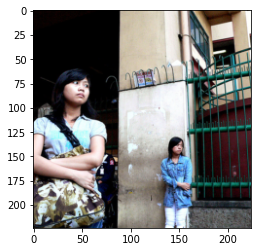

greedy search:  gain dumps headlights impact client bridesmaids tier time prestends legged ages manequins film wakeboard forehead yougn roughly bandmates yellow-gold rottwieler serve entertain cards perfomed swordfight brightly-colred equestrian foot waterhole mechanical
beam search 1:  gain dumps headlights impact client bridesmaids tier time prestends legged ages manequins film wakeboard forehead yougn roughly bandmates yellow-gold rottwieler serve entertain cards perfomed swordfight brightly-colred equestrian foot waterhole mechanical outstreched
beam search 3:  hammer anouther peaking astonishment woolen pre-teen grip effort sledder cameras wicker miniature cameras wicker miniature farris vaulter retail massage bongo woolen pre-teen backwards 528 longhaired rebound tire waiting 22 childern redhead
beam search 5:  geyser rocking rocking rocking rocking rocking rocking rocking flakes rocking rocking rocking rocking rocking rocking rocking rocking rocking rocking rocking rocking rocki

In [ ]:
def inference(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  for i in df_test['image'].sample(n=1).tolist():
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    image2 = image
    image2[0] = image2[0] * 0.229
    image2[1] = image2[1] * 0.224 
    image2[2] = image2[2] * 0.225 
    image2[0] += 0.485 
    image2[1] += 0.456 
    image2[2] += 0.406
    plt.imshow(image2.permute(1,2,0))
    plt.show()
    image = image.unsqueeze(0)
    image = image.to(device)

    print('greedy search: ', greedy_predict(model, image, vocab, device, max_length = 30))
    print('beam search 1: ', beam_search_predict(model, image, vocab, device, max_length = 30, beam = 1, show_step = False))
    print('beam search 3: ', beam_search_predict(model, image, vocab, device, max_length = 30, beam = 3, show_step = False))
    print('beam search 5: ', beam_search_predict(model, image, vocab, device, max_length = 30, beam = 5, show_step = False))


inference(df_test)


In [ ]:
model.train() 

best_eval_loss = 10000
val_interval = 2

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    print('epoch: ', epoch+1)
    checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_Attention_Only.pth.tar')

    total_train_loss = 0
    step = 0

    for idx, (imgs, captions) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
        step += 1
        imgs = imgs.to(device)
        captions = captions.to(device)

        output = model(imgs, captions) 
        optimizer.zero_grad()

        # captions shape: [batch_size ,sequence_length]
        # output.shape : [batch_size, sequence_length, vocab_size]
        # loss entropy loss:
            # input: (N, C)
            # output: (N)
        loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

        total_train_loss += loss.item()
        
        loss.backward()

        # CLIPPING Method
        clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
        
    scheduler.step()
    total_train_loss = total_train_loss / step
    train_loss_list.append(total_train_loss)
    print('Train loss: {}'.format(total_train_loss))
    
    
    ## for inference
    inference(df_test)

    val_total_loss = 0
    val_step = 0

    if (epoch + 1) % val_interval == 0:
      with torch.no_grad():
        for idx, (imgs, captions) in tqdm(enumerate(val_dataloader), total=len(val_dataloader), leave=False):
          val_step += 1
          imgs = imgs.to(device)
          captions = captions.to(device)

          output = model(imgs, captions) 
          loss = loss_criterion(output.reshape(-1, output.shape[2]), captions.reshape(-1))

          val_total_loss += loss.item()        
          
        val_total_loss = val_total_loss / val_step
        val_loss_list.append(val_total_loss)
        print('val loss: {}'.format(val_total_loss))

      if val_total_loss < best_eval_loss:
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        save_checkpoint(checkpoint, filename = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_BEST_Attention_Only.pth.tar')



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
with open('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_Attention_Only_Train.txt', 'a') as testwritefile_train:
  for index, i in enumerate(train_loss_list):
    testwritefile_train.write('step :{}, loss score: {}\n'.format(index,i))

with open('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_Attention_Only_Val.txt', 'a') as testwritefile_val:
  for index, i in enumerate(val_loss_list):
    testwritefile_val.write('step :{}, loss score: {}\n'.format(index,i))

NameError: ignored

In [ ]:
from collections import defaultdict
test_dic = defaultdict(list)

for i in range(len(df_test)):
  img = df_test.iloc[i,:]['image']
  caption = df_test.iloc[i,:]['caption']
  test_dic[img].append(caption)

In [ ]:
!pip install torchmetrics

from torchmetrics.functional import bleu_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 27.2 MB/s 


In [ ]:
model = CNN2Attention( vocab_size = vocab_size, 
                       embed_size = embed_size,
                       num_layers = num_layers,
                       heads = num_heads,
                       forward_expansion = forward_expansion,
                       dropout = dropout,
                       device = device).to(device)

model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/CNN_BEST_Attention_Only.pth.tar')['state_dict'])

<All keys matched successfully>

In [ ]:
def inference(df_test):
  image_path = '/content/gdrive/MyDrive/Colab Notebooks/Image Captioning/Flickr8k/Images'

  transform = transforms.Compose([
      transforms.Resize(232),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  candidate_corpus_gp = []
  candidate_corpus_bm1 = []
  candidate_corpus_bm3 = []
  candidate_corpus_bm5 = []
  references_corpus = []

  for i in list(test_dic.keys()):
    test = [i.lower() for i in test_dic[i]]
    references_corpus.append(test)
    image = Image.open(os.path.join(image_path, i)).convert('RGB')
    image = transform(image)
    # image2 = image
    # image2[0] = image2[0] * 0.229
    # image2[1] = image2[1] * 0.224 
    # image2[2] = image2[2] * 0.225 
    # image2[0] += 0.485 
    # image2[1] += 0.456 
    # image2[2] += 0.406
    # plt.imshow(image2.permute(1,2,0))
    # plt.show()
    image = image.unsqueeze(0)
    image = image.to(device)

    gp = greedy_predict(model, image, vocab, device, max_length = 30)
    bm1 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 1, show_step = False)
    bm3 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 3, show_step = False)
    bm5 = beam_search_predict(model, image, vocab, device, max_length = 30, beam = 5, show_step = False)

    # print('greedy search: ', gp)
    # print('beam search 1: ', bm1)
    # print('beam search 3: ', bm3)
    # print('beam search 5: ', bm5)

    candidate_corpus_gp.append(gp)
    candidate_corpus_bm1.append(bm1)
    candidate_corpus_bm3.append(bm3)
    candidate_corpus_bm5.append(bm5)
    
  print('Greedy ')
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=1))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=2))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=3))
  print(bleu_score(candidate_corpus_gp, references_corpus, n_gram=4))

  print('BS 1')
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm1, references_corpus,n_gram=4))

  print('BS 3')
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm3, references_corpus,n_gram=4))

  print('BS 5')
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=1))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=2))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=3))
  print(bleu_score(candidate_corpus_bm5, references_corpus,n_gram=4))
    

inference(df_test)


Greedy 
tensor(0.4647)
tensor(0.2724)
tensor(0.1644)
tensor(0.0973)
BS 1
tensor(0.4648)
tensor(0.2725)
tensor(0.1644)
tensor(0.0973)
BS 3
tensor(0.5430)
tensor(0.3158)
tensor(0.1897)
tensor(0.1148)
BS 5
tensor(0.5565)
tensor(0.3189)
tensor(0.1863)
tensor(0.1097)
